# Understanding Hodgkin-Huxley Model

###### Imports

In [1]:
# Custom Modules
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
from modules.hh_model import HodgkinHuxleyNeuron
from concept.hh_model import HodgkinHuxleyNeuron as NoJitHodgkinHuxleyNeuron

# Standard Modules
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Numba
from numba import njit, float64, typed, int32, typeof
from numba.experimental import jitclass
from numba.core import types
from numba.typed import Dict as NumbaDict, List as NumbaList
from typing import List, Dict
import time as tm

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

###### Post-Synaptic Function

In [2]:
def I_postsyn(cur_V, par_V):
    weight = 0.1
    tau = 30
    I_syn = weight * np.exp(-(cur_V - par_V) / tau)
    return I_syn

## Single Neuron

In [3]:
T = 100
step = dt = 0.001
time = np.arange(0, T, dt)
weight = 0.1
tau = 30
I_inp = np.zeros(len(time))
I_inp[int(0.5/dt):int(1.0/dt)] = 15.0
V_record = []
I_out = np.zeros(len(time))


start  = tm.time()
neuron = HodgkinHuxleyNeuron(dt)
for i in range(len(time)):
    neuron.step(I_inp[i])
    V_record.append(neuron.V)
    I_out[i] = weight * np.exp(-(-65.0 - neuron.V) / tau)

end = tm.time()
jit_time = end - start


V_record = []
I_out = np.zeros(len(time))
start  = tm.time()
neuron = NoJitHodgkinHuxleyNeuron(dt)
for i in range(len(time)):
    neuron.step(I_inp[i])
    V_record.append(neuron.V)
    I_out[i] = weight * np.exp(-(-65.0 - neuron.V) / tau)

end = tm.time()
no_jit_time = end - start
print(f"JIT Execution Time: {jit_time} seconds")
print(f"No JIT Execution Time: {no_jit_time} seconds")
print(f"Speedup: {round(no_jit_time / jit_time, 2)}")

JIT Execution Time: 2.4762892723083496 seconds
No JIT Execution Time: 4.833310842514038 seconds
Speedup: 1.95


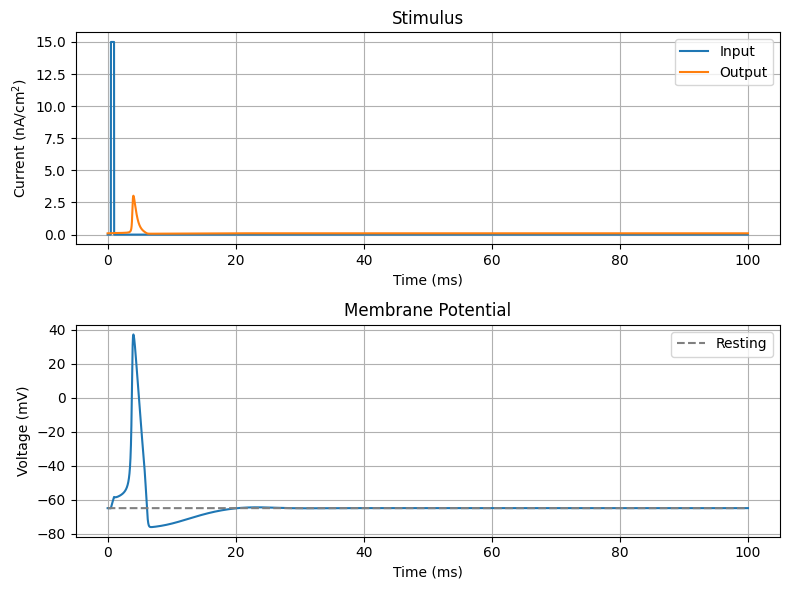

In [4]:
# Plot
plt.figure(figsize=(8, 6))
    
# Membrane potential V
plt.subplot(2, 1, 2)
plt.plot(time, V_record)
plt.plot(time, np.full(len(time), -65), linestyle='--', color='gray', label='Resting')
plt.title('Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.grid()
plt.legend()

# Currents
plt.subplot(2, 1, 1)
plt.plot(time, I_inp, label='Input')
plt.plot(time, I_out, label='Output')
plt.title('Stimulus')
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA/cm$^2$)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### Dynamics in Neurons

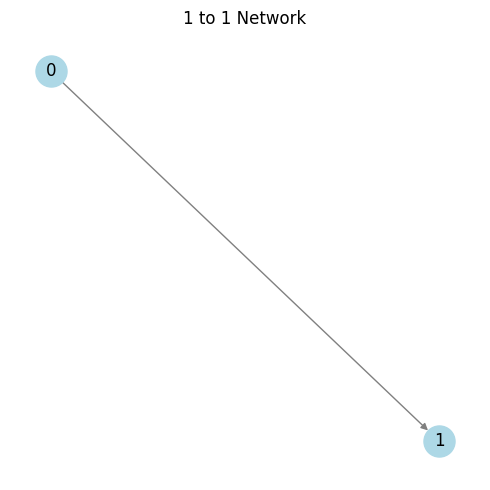

In [6]:
def create_N_to_1(N):
    network = nx.DiGraph()
    network.add_nodes_from(range(N))

    for i in range(N - 1):
        network.add_edge(i, N - 1)

    for node in network.nodes():
        network.nodes[node]['neuron'] = HodgkinHuxleyNeuron(step)

    return network
    

def plot_network(network, ax):
    pos = nx.spring_layout(network)
    nx.draw_networkx(network, pos, node_size=500, node_color="lightblue", edge_color="gray", arrows=True, ax=ax)
    ax.set_title(f"{len(network.nodes) - 1} to 1 Network")
    ax.axis("off")
    plt.tight_layout()


# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
Net2 = create_N_to_1(2)
plot_network(Net2, ax)

##### Simulation

In [9]:
def sim(network):
    # Record Data
    V_record = {node: [] for node in network.nodes()}
    Network = network.nodes()
    
    for i in range(len(time)):
        for node in Network:
            neuron = Network[node]['neuron']
            I_temp = 0.0

            if node in range(len(Network) - 1):
                neuron.step(dt, I_inp[i])
                V_record[node].append(neuron.V)
            else:
                for pred in list(network.predecessors(node)):
                    parent = Network[pred]['neuron']
                    I_temp += I_postsyn(neuron.V, parent.V)
        
                neuron.step(dt, I_temp)
                V_record[node].append(neuron.V)

    return V_record


def plot_sim(Vs, ax):
    for node, V in Vs.items():
        ax.plot(step, V, label=f'Neuron {node}')

    ax.plot(step, np.full(len(step), -65.0), linestyle='--', label='Resting', color='gray')  
    ax.set_title("Membrane Potential")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    ax.grid()
    ax.legend()


Vs = sim(Net2)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_sim(Vs, ax)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1m[1m- Resolution failure for literal arguments:
[1m[1mCannot bind 'args=(instance.jitclass.HodgkinHuxleyNeuron#7c8f40701330<dt:float64,C_m:float64,V:float64,g_Na:float64,E_Na:float64,m:float64,h:float64,g_K:float64,E_K:float64,n:float64,g_L:float64,E_L:float64>, float64, float64) kws={}' to signature '(self, I)' due to "TypeError: too many positional arguments".[0m[0m
[0m[1m- Resolution failure for non-literal arguments:
[1mNone[0m
[0m[0m
[0m[1mDuring: resolving callee type: BoundFunction((<class 'numba.core.types.misc.ClassInstanceType'>, 'step') for instance.jitclass.HodgkinHuxleyNeuron#7c8f40701330<dt:float64,C_m:float64,V:float64,g_Na:float64,E_Na:float64,m:float64,h:float64,g_K:float64,E_K:float64,n:float64,g_L:float64,E_L:float64>)[0m
[0m[1mDuring: typing of call at <string> (3)
[0m
[1m
File "<string>", line 3:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: Pass nopython_type_inference[0m

## Multiple Neurons

In [ ]:
NetA = create_N_to_1(4)
NetB = create_N_to_1(5)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
plot_network(NetA, axes[0])
plot_network(NetB, axes[1])

##### Simulation

In [ ]:
VsA = sim(NetA)
VsB = sim(NetB)

# Plot
plt.figure(figsize=(8, 6))

# Currents
plt.subplot(2, 1, 1)
plt.plot(step, I_inp, label='Input')
plt.plot(step, I_out, label='Output')
plt.title('Stimulus')
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA/cm$^2$)')
plt.legend()
plt.grid()

# Membrane potential V
plt.subplot(2, 1, 2)
plt.plot(step, V_record)
plt.plot(step, np.full(len(step), -65.0),
         linestyle='--', color='gray', label='Resting')
plt.title('Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_sim(VsA, axes[0])
plot_sim(VsB, axes[1])

##### Cycles

In [ ]:
network = nx.DiGraph()
network.add_nodes_from(range(3))

network.add_edge(0, 1)
network.add_edge(1, 2)
network.add_edge(2, 0)

for node in network.nodes():
    network.nodes[node]['neuron'] = HodgkinHuxleyNeuron()

fig, axes = plt.subplots(1, 2, figsize=(8, 6))



V_record = {node: [] for node in network.nodes()}
Network = network.nodes()

for i, t in enumerate(step):
    for node in Network:
        neuron = Network[node]['neuron']
        I_temp = 0.0

        if node == 0:
            neuron.step(dt, I_inp[i])
            V_record[node].append(neuron.V)
        else:
            for pred in list(network.predecessors(node)):
                parent = Network[pred]['neuron']
                I_temp += I_postsyn(neuron.V, parent.V)
    
            neuron.step(dt, I_temp)
            V_record[node].append(neuron.V)


plot_network(network, axes[0])
plot_sim(V_record, axes[1])

##